# Segment Anything in Multi-Backend Keras

This demo notebook demonstrates how to get the weights ported from PyTorch to multi-backend Keras and how to use the ported model to segment images in multi-backend Keras! The demo mirrors the predictor demo on the facebook/segment_anything repo.

It includes:

- Porting weights of the PyTorch model to the multi-backend Keras model.
- Using the multi-backend Keras port of the predictor model to extract masks from a given image and prompt.

### TODOs

- Ian: Port the `ResizeLongestSide.apply_image` method to multi-backend Keras with support for `uint8` images (or maybe don't, we can just use PIL/OpenCV or something).
- Tirth: Saving model or model weights doesn't work after porting them. I think this might be because I don't define `get/set_config` methods... But I think, for the time being, we can let the weight porting script run everything we want to run the demo since it doesn't take very long.
- ~Tirth: Port the model to Keras Core.~
- Tirth: Benchmark the model against the PyTorch model.

In [1]:
%%capture
pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
%%capture
pip install -U keras-core keras-cv

In [3]:
%%shell
git clone -b keras-core-support https://github.com/tirthasheshpatel/segment_anything_tensorflow.git
mkdir -p sam_tf
mv -f segment_anything_tensorflow/sam_tf/* sam_tf/
mv -f segment_anything_tensorflow/weights_porter.py  ./

Cloning into 'segment_anything_tensorflow'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 121 (delta 76), reused 84 (delta 42), pack-reused 0
Receiving objects: 100% (121/121), 6.25 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [4]:
# Get the image for the demo
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg -o truck.jpg
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg -o groceries.jpg

In [5]:
# Get the huge PyTorch model weights
!curl -sSL https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -o sam_vit_h_4b8939.pth

# Porting Weights

In [6]:
import os

os.environ['KERAS_CV_MULTI_BACKEND'] = "1"
os.environ['KERAS_BACKEND'] = "jax"
os.environ['JAX_ENABLE_X64'] = "1"

In [7]:
import sys
import json
import glob
from pprint import pprint
import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools import mask as mask_utils

# torch model
import torch
from segment_anything.build_sam import build_sam_vit_h
from segment_anything.modeling import Sam
from segment_anything import sam_model_registry, SamPredictor

# tensorflow model
import keras_core as keras
from keras_core.src import ops
from sam_tf.image_encoder import ImageEncoder
from sam_tf.prompt_encoder import PromptEncoder
from sam_tf.mask_decoder import MaskDecoder, TwoWayTransformer
from sam_tf.sam import SegmentAnythingModel
from weights_porter import port_weights_huge

Using JAX backend.


In [8]:
# Define the huge model in TensorFlow

image_encoder = ImageEncoder(
    img_size=1024,
    patch_size=16,
    in_chans=3,
    embed_dim=1280,
    depth=32,
    mlp_dim=1280*4,
    num_heads=16,
    out_chans=256,
    use_bias=True,
    use_rel_pos=True,
    window_size=14,
    global_attention_indices=[7, 15, 23, 31]
)

prompt_encoder = PromptEncoder(
    embed_dim=256,
    image_embedding_size=(64, 64),
    input_image_size=(1024, 1024),
    mask_in_chans=16
)

mask_decoder = MaskDecoder(
    transformer_dim=256,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=256,
        mlp_dim=2048,
        num_heads=8
    ),
    num_multimask_outputs=3,
    iou_head_depth=3,
    iou_head_hidden_dim=256
)

In [9]:
# Forward Pass to build the model

x = ops.ones((1, 1024, 1024, 3))
x_embeddings = image_encoder(x)

points = ops.convert_to_tensor(
    np.random.randint(0, 1023, (7, 10, 2)),
    dtype="float32"
)
labels = ops.convert_to_tensor(
    1 * (np.random.rand(7, 10) > 0.5),
    dtype="int64"
)
box = ops.array(
    [[[[10, 10], [500, 500]],
      [[20, 20], [500, 500]],
      [[30, 30], [500, 500]],
      [[40, 40], [500, 500]],
      [[50, 50], [500, 500]],
      [[60, 60], [500, 500]],
      [[70, 70], [500, 500]]]],
    dtype="float32"
)
mask = ops.convert_to_tensor(
    1. * (np.random.rand(7, 256, 256, 1) > 0.5),
    dtype="float32"
)

sparse_embeddings, dense_embeddings = prompt_encoder(
    points=points,
    labels=labels,
    box=box,
    mask=mask
)

masks_pred, iou_pred = mask_decoder(
    image_embeddings=x_embeddings,
    image_pe=prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings[:1, ...],
    dense_prompt_embeddings=dense_embeddings[:1, ...],
    multimask_output=True
)

In [10]:
model = SegmentAnythingModel(image_encoder, prompt_encoder, mask_decoder)

In [11]:
# We create a predictor to port the weights from PyTorch to TensorFlow

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to("cuda")

predictor = SamPredictor(sam)

In [12]:
# Port the PyTorch model's weights to the multi-backend Keras model
port_weights_huge(model, predictor.model)

# Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [14]:
# Re-implementation of https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/utils/transforms.py#L16 in TensorFlow
class ResizeLongestSide:
    def __init__(self, target_length):
        self.target_length = target_length

    def apply_image(self, image):
        target_size = self.get_preprocess_shape(image.shape[1], image.shape[2])
        return ops.image.resize(
            image, size=target_size, method="bilinear"
        )

    def apply_coords(self, coords, original_size):
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(original_size[0], original_size[1])
        coords = ops.cast(coords, "float32")
        coords_x = coords[..., 0] * (new_w / old_w)
        coords_y = coords[..., 1] * (new_h / old_h)
        return ops.stack([coords_x, coords_y], axis=-1)

    def apply_boxes(self, boxes, original_size):
        boxes = self.apply_coords(
            ops.reshape(
                boxes, (-1, 2, 2)
            ),
            original_size
        )
        return boxes

    def get_preprocess_shape(self, old_h, old_w):
        scale = self.target_length * 1.0 / max(old_h, old_w)
        new_h = old_h * scale
        new_w = old_w * scale
        return int(new_h + 0.5), int(new_w + 0.5)

In [15]:
transform  = ResizeLongestSide(1024)

# Example Image

In [16]:
image = cv2.imread('truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

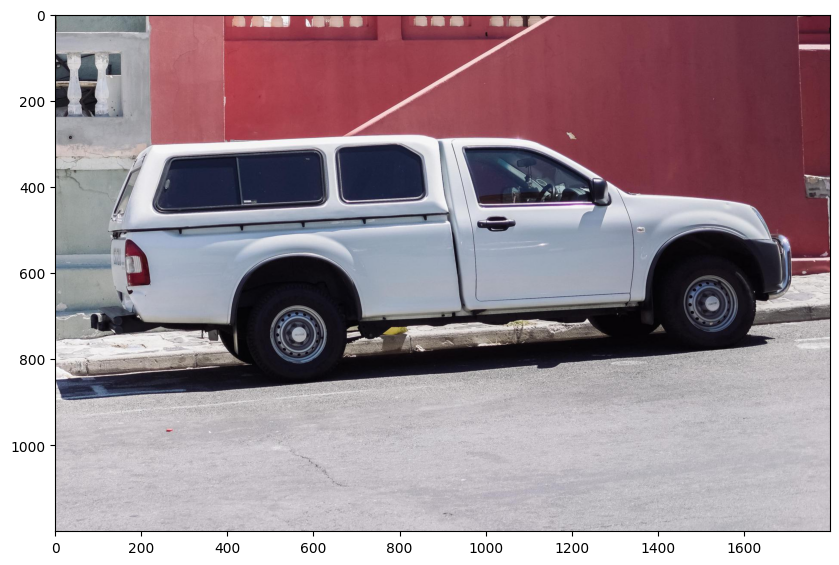

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [18]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

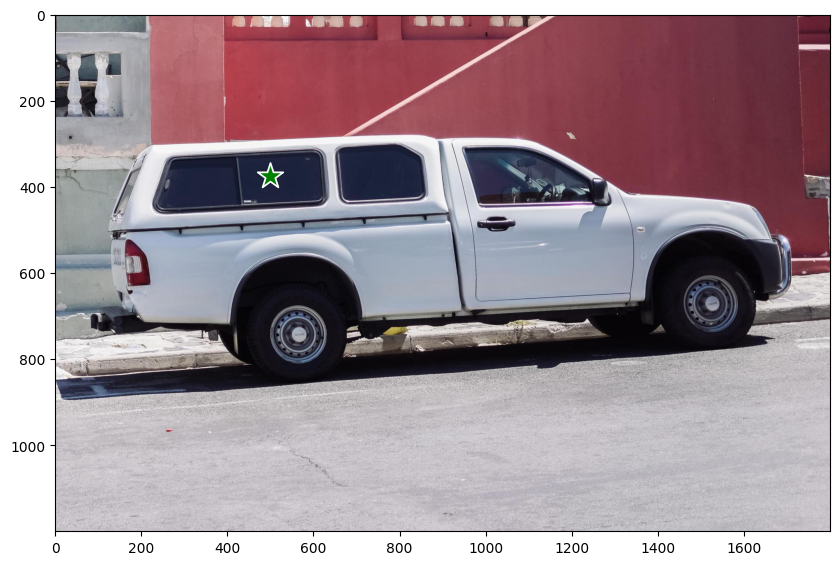

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [20]:
image_record = {}

# TODO(ianstenbit) -- torchvision.transforms.functional.resize allows uint8 images but I can't find anything equivalent in TensorFlow.
# Temporarily using the PyTorch resize transform to make sure the image is numerically equal to the PyTorch model.
image_record["image"] = ops.convert_to_tensor(predictor.transform.apply_image(image)[np.newaxis, ...], dtype="float32")

image_record["original_size"] = (image.shape[0], image.shape[1])

image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 1, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

In [21]:
out = model.call([image_record])
masks, scores, logits = out[0]["masks"], out[0]["iou_predictions"], out[0]["low_res_masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks, scores, logits = map(ops.convert_to_numpy, [masks[0], scores[0], logits[0]])

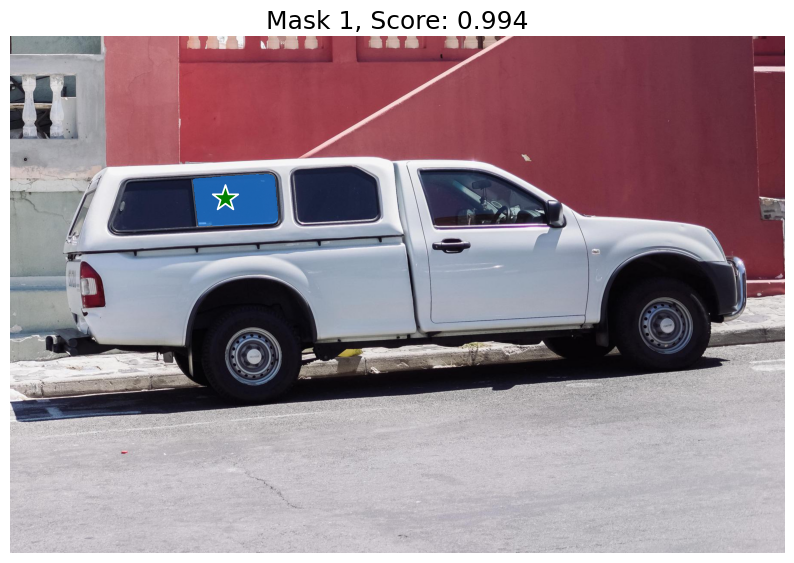

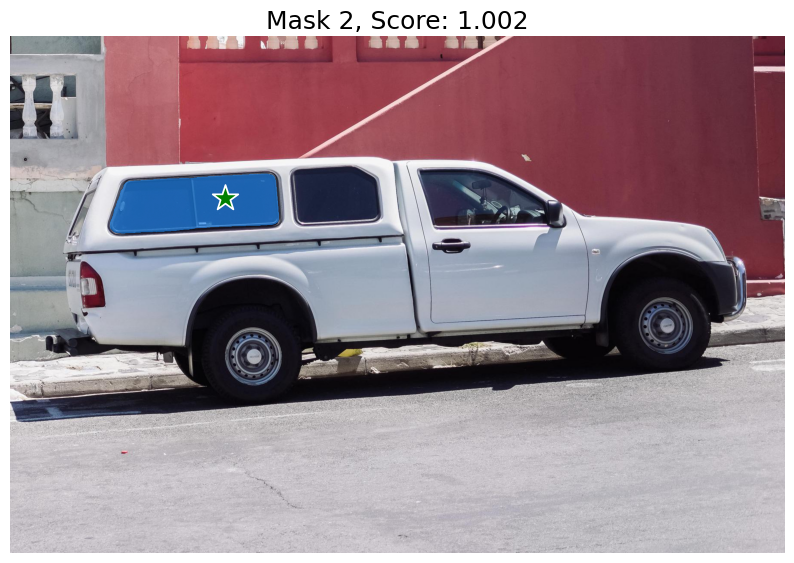

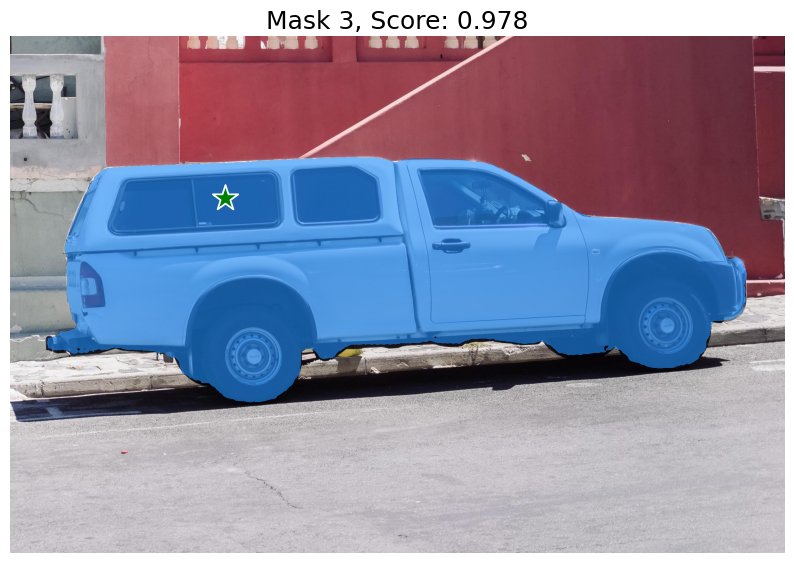

In [22]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [23]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :, np.newaxis]  # Choose the model's best mask

In [24]:
image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 2, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

image_record["mask_inputs"] = ops.convert_to_tensor(mask_input[np.newaxis, ...])

In [25]:
out = model.call([image_record], multimask_output=False)
masks = out[0]["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks[0])

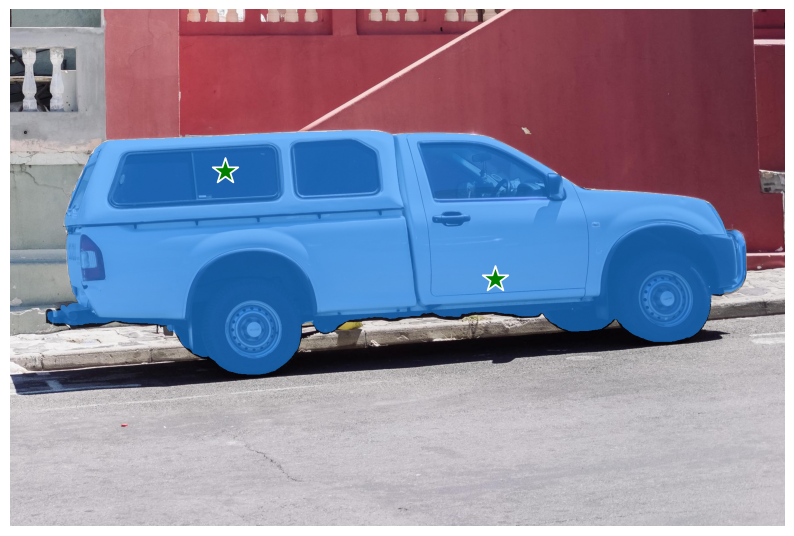

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0, ...], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [27]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :, np.newaxis]  # Choose the model's best mask

In [28]:
image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 2, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

image_record["mask_inputs"] = ops.convert_to_tensor(mask_input[np.newaxis, ...])

In [29]:
out = model.call([image_record], multimask_output=False)
masks = out[0]["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks[0])

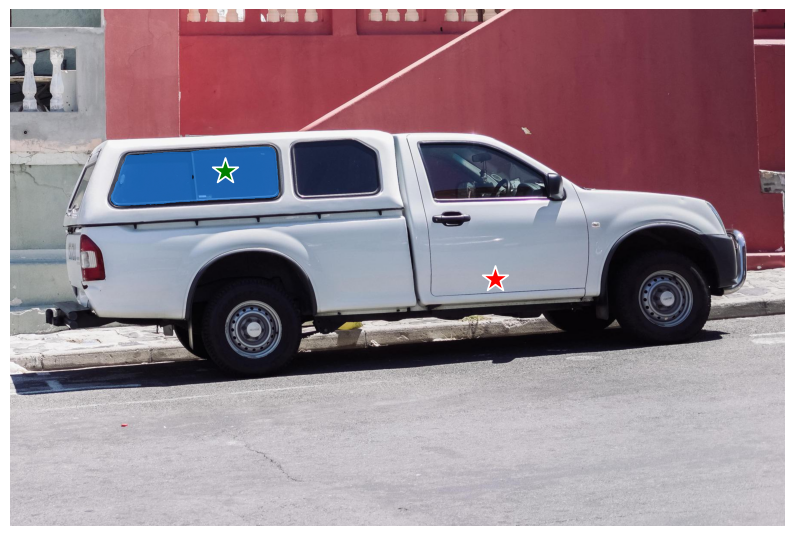

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0, ...], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [31]:
input_box = np.array([425, 600, 700, 875])

In [32]:
image_record["boxes"] = ops.reshape(
    ops.convert_to_tensor(
        input_box, dtype="float32"
    ),
    (1, 4)
)
image_record["boxes"] = transform.apply_boxes(
    image_record["boxes"], image_record["original_size"]
)

In [33]:
# Remove the mask input, point_coords, and point_labels
_ = image_record.pop("mask_inputs", None)
_ = image_record.pop("point_coords", None)
_ = image_record.pop("point_labels", None)

In [34]:
out = model.call([image_record], multimask_output=False)
masks = out[0]["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks[0])

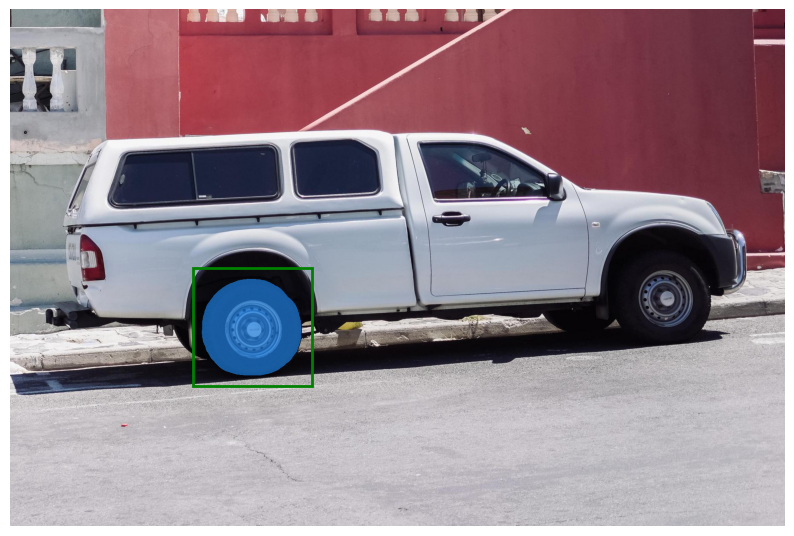

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

# Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [36]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [37]:
image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 1, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

image_record["boxes"] = ops.reshape(
    ops.convert_to_tensor(
        input_box, dtype="float32"
    ),
    (1, 4)
)
image_record["boxes"] = transform.apply_boxes(
    image_record["boxes"], image_record["original_size"]
)

In [38]:
out = model.call([image_record], multimask_output=False)
masks = out[0]["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks[0])

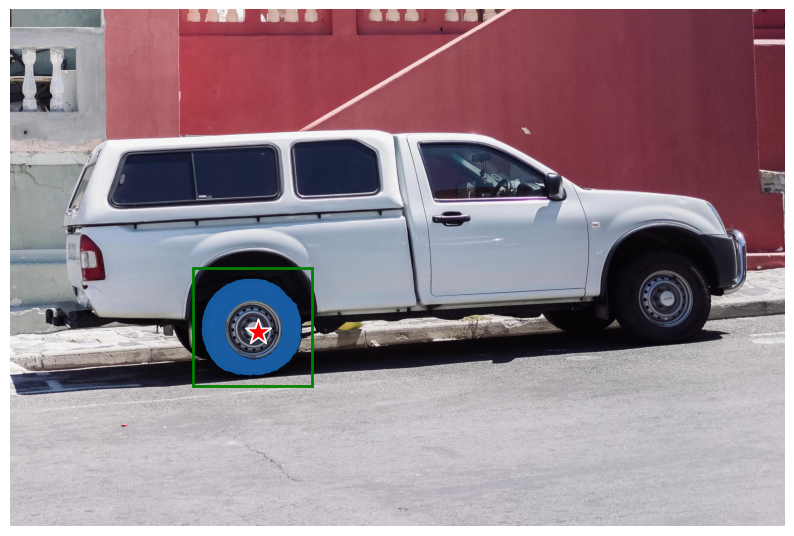

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# Batched prompt inputs

In [40]:
input_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

In [41]:
image_record["boxes"] = ops.reshape(
    ops.convert_to_tensor(
        input_boxes, dtype="float32"
    ),
    (4, 4)
)
image_record["boxes"] = transform.apply_boxes(
    image_record["boxes"], image_record["original_size"]
)

# Remove the mask input, point_coords, and point_labels
_ = image_record.pop("mask_inputs", None)
_ = image_record.pop("point_coords", None)
_ = image_record.pop("point_labels", None)

In [42]:
out = model.call([image_record], multimask_output=False)
masks = out[0]["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)

In [43]:
masks.shape

(4, 1, 1200, 1800)

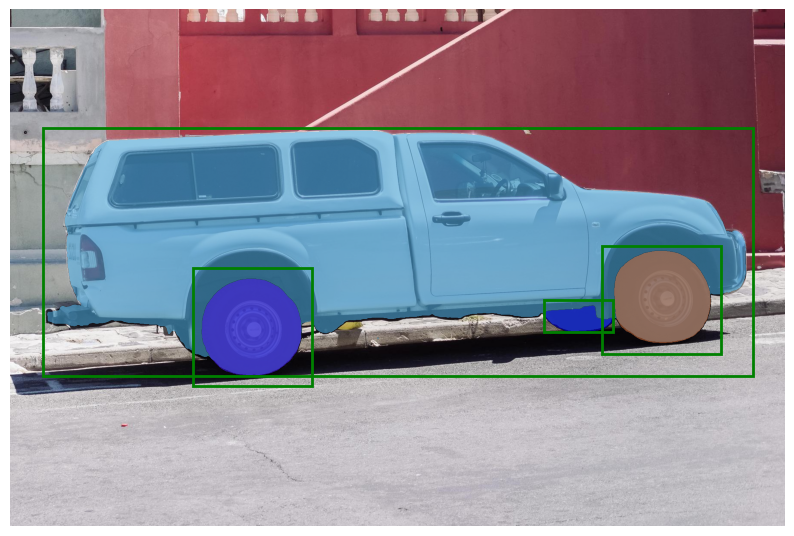

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

# End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

Both images and prompts are input as TensorFlow tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:

- `image`: The input image as a TensorFlow tensor in `(1, H, W, C)` format.
- `original_size`: The size of the image before transforming for input to SAM, in `(H, W)` format.
- `point_coords`: Batched coordinates of point prompts.
- `point_labels`: Batched labels of point prompts.
- `boxes`: Batched input boxes.
- `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

The output is a list over results for each input image, where list elements are dictionaries with the following keys:

- `masks`: A batched TensorFlow tensor of predicted probability masks, the size of the original image.
- `iou_predictions`: The model's prediction of the quality for each mask.
- `low_res_masks`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [45]:
image1 = image
image1_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

image2 = cv2.imread('groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = np.array([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
])

In [46]:
batched_input = [
     {
         'image': ops.convert_to_tensor(predictor.transform.apply_image(image1)[np.newaxis, ...], dtype="float32"),
         'boxes': transform.apply_boxes(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': ops.convert_to_tensor(predictor.transform.apply_image(image2)[np.newaxis, ...], dtype="float32"),
         'boxes': transform.apply_boxes(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

In [47]:
batched_output = model.call(batched_input, multimask_output=False)

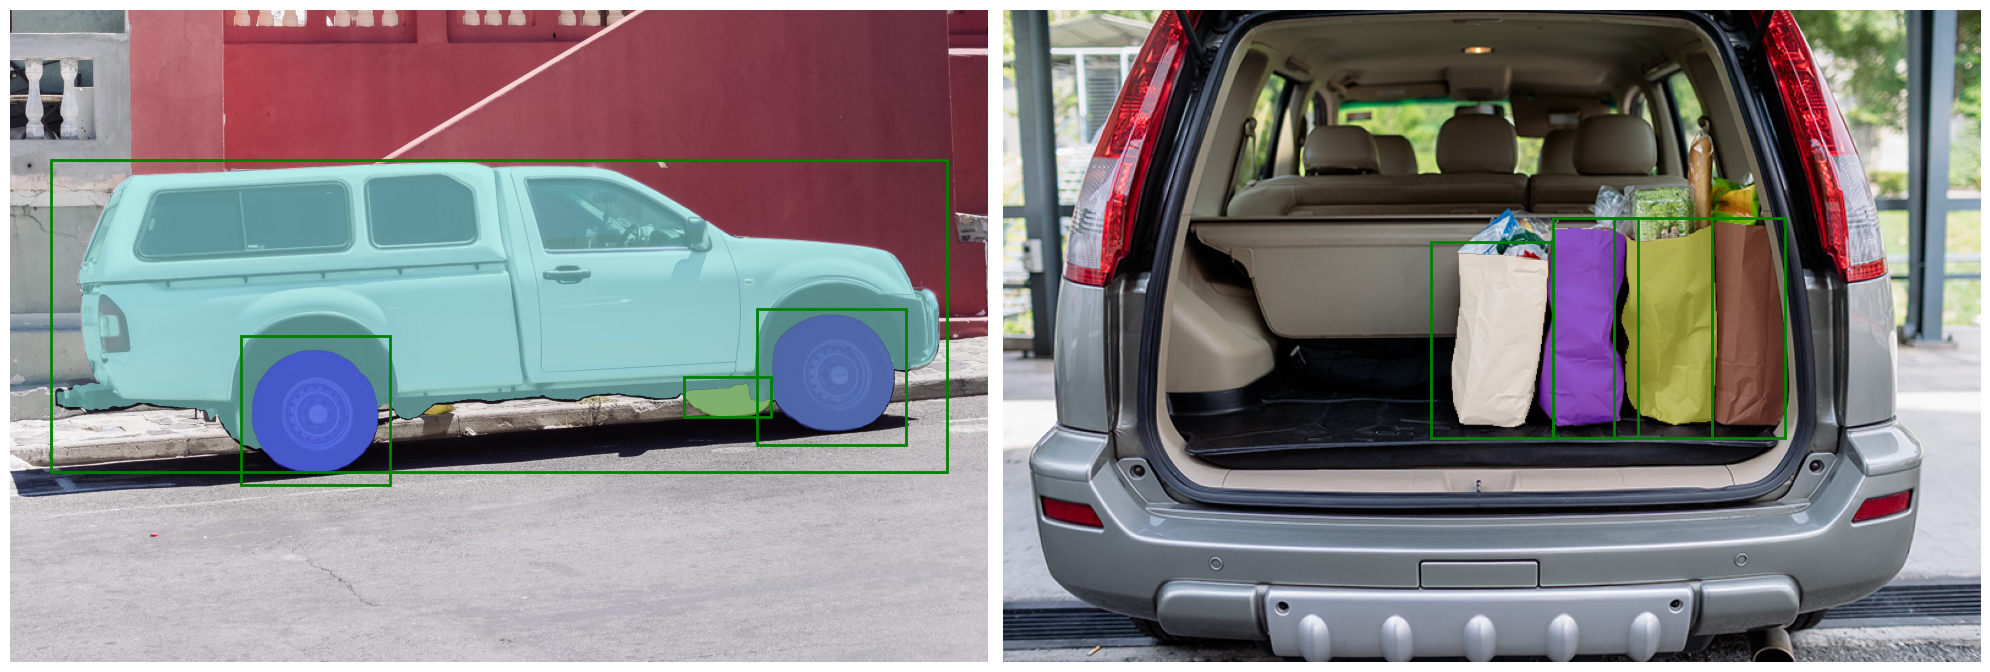

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    mask = ops.cast(mask > 0.0, dtype="float32")
    show_mask(ops.convert_to_numpy(mask), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box, ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    mask = ops.cast(mask > 0.0, dtype="float32")
    show_mask(ops.convert_to_numpy(mask), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box, ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()

# [WIP] Benchmarks

In [49]:
# Benchmark the TensorFlow model against the PyTorch model on CPU.
# Looks like they both perform pretty similar...

In [50]:
# %%time
# out = model.call([image_record])

In [51]:
# %%time
# out = predictor.set_image(image)
# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=True,
# )